In [4]:
import datetime
import statistics
from collections import defaultdict
from dataclasses import dataclass
import json
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as pltd
import numpy as np
import pandas as pd
import seaborn as sns
from sqlalchemy.orm import Session, lazyload, joinedload
from sqlalchemy import select, desc, and_, create_engine
import toml
import typed_settings as ts

from paralysis.settings import ParalysisSettings
from paralysis.model import Round, Feedback, LegacyPopulation

In [2]:
sns.set_theme()
settings = ts.load(ParalysisSettings, appname="paralysis", config_files=["prod.toml"])
engine = create_engine(settings.connection_string)
SESSION = Session(engine)

In [5]:
YEARS = [2021, 2022, 2023, 2024, 2025]
yearly_pops = {}
for year in YEARS:
    query = select(LegacyPopulation.playercount, LegacyPopulation.time).filter(
        and_(
            LegacyPopulation.time >= datetime(year, 1, 1),
            LegacyPopulation.time < datetime(year + 1, 1, 1),
        )
    ).order_by(LegacyPopulation.time)

    df = pd.read_sql_query(query, SESSION.connection())
    yearly_pops[year] = df.set_index(pd.DatetimeIndex(df['time']))

daily_pops = {}
for year in YEARS:
    daily_pops[year] = yearly_pops[year].playercount.groupby(yearly_pops[year].index.dayofyear).mean().astype(int)

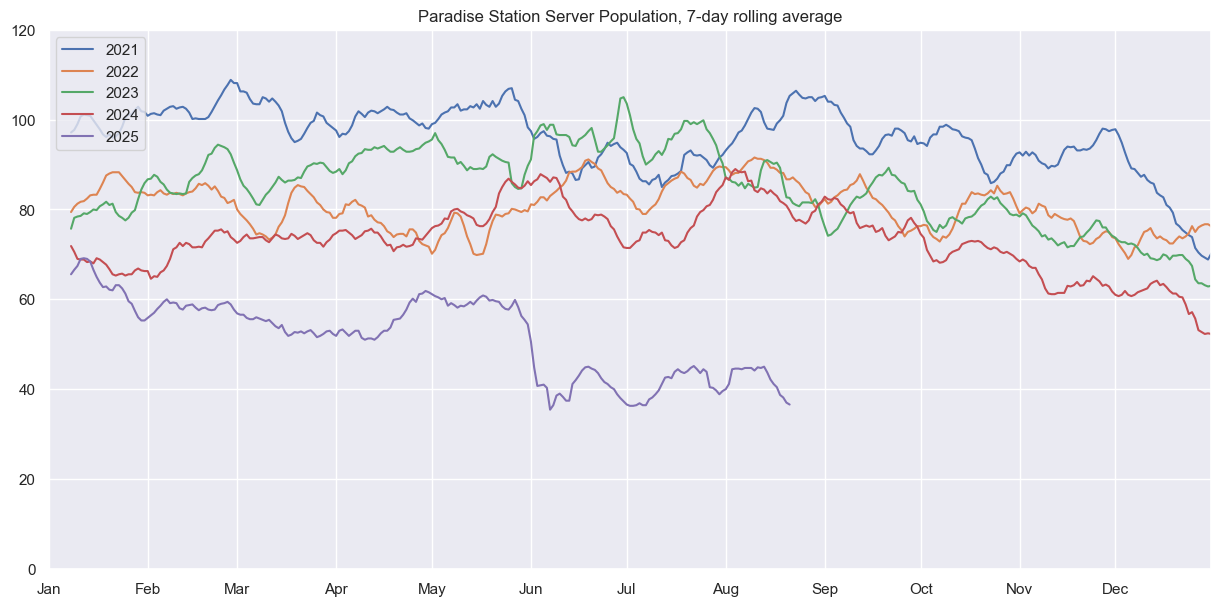

In [6]:
rolling_avg_days = 7
fig, ax=plt.subplots(1, 1, figsize=(15, 7))
ax.set_xlim(np.datetime64('1970-01-01'), np.datetime64('1970-12-31'))
ax.set_ylim(0, 120)
ax.xaxis.set_major_locator(pltd.MonthLocator())
ax.xaxis.set_major_formatter(pltd.DateFormatter('%b'))
ax.margins(x=0)

for year in YEARS:
    plt.plot(daily_pops[year].rolling(rolling_avg_days).mean(), label=f'{year}')

plt.title(f"Paradise Station Server Population, {rolling_avg_days}-day rolling average")
plt.legend(loc='upper left')
plt.savefig(f"server_population_rolling_avg_{YEARS[0]}_{YEARS[-1]}.png")